In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
! eups list -s

afw                   g4728e35f0d+53a8438ab4 	current w_2023_38 setup
alert_packet          g6041bd2d66 	current w_2023_38 setup
analysis_drp          g8a53795882+8240499edc 	current w_2023_38 setup
analysis_tools        g1887775915+c89e410209 	current w_2023_38 setup
ap_association        g6a6fcd37b7+f81e0a4cd9 	current w_2023_38 setup
ap_pipe               g06c608b3b8+0cce5f0898 	current w_2023_38 setup
ap_verify             gf37a9491f6+9462b9949d 	current w_2023_38 setup
astro_metadata_translator g0978aabd1f+0ce179faa8 	current w_2023_38 setup
astshim               g3273194fdb+f6908454ef 	current w_2023_38 setup
atmospec              LOCAL:/home/m/monroy/repos/repos_w_2023_35/atmospec 	setup
base                  g98ffbb4407+81bc2a20b4 	current w_2023_38 setup
cbp                   ga32fcf49c8+387721ca5c 	current w_2023_38 setup
cell_coadds           g9faf7ed3f3+8240499edc 	current w_2023_38 setup
coadd_utils           g337abbeb29+387721ca5c 	current w_2023_38 setup
cp_pipe         

# Butler 

In [6]:
import lsst.daf.butler as dafButler

In [7]:
embargo = True

In [8]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

In [9]:
cameraName = 'LATISS'
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)

# Paths 

In [10]:
outdir_base = 'output_fits/'
if os.path.exists(outdir_base)==False:
    os.mkdir(outdir_base)
outdir_label = 'cyl_lens_flat_{0}/'

We check the different dimension records existing for *physical_filter*: 

In [11]:
phys_filters = list(registry.queryDimensionRecords('physical_filter',where="instrument='LATISS'"))

Print physical_filters with hologram in place: 

In [12]:
for f_ in phys_filters:
    if 'holo' in f_.name:
        print(f_.name)

empty~holo4_003
blank_bk7_wg05~holo4_003
KPNO_1111_436nm~holo4_003
KPNO_373A_677nm~holo4_003
KPNO_406_828nm~holo4_003
unknown~holo4_003
BG40~holo4_003
quadnotch1~holo4_003
RG610~holo4_003
FELH0600~holo4_003
SDSSg~holo4_003
SDSSr~holo4_003
SDSSi~holo4_003
BG40_65mm_1~holo4_003
BG40_65mm_2~holo4_003
OG550_65mm_1~holo4_003
OG550_65mm_2~holo4_003
SDSSg_65mm~holo4_003
SDSSr_65mm~holo4_003
SDSSi_65mm~holo4_003
SDSSu_65mm~holo4_003
SDSSz_65mm~holo4_003
SDSSy_65mm~holo4_003
empty~holo4_001
blank_bk7_wg05~holo4_001
KPNO_1111_436nm~holo4_001
KPNO_373A_677nm~holo4_001
KPNO_406_828nm~holo4_001
unknown~holo4_001
BG40~holo4_001
BG40_65mm_1~holo4_001
BG40_65mm_2~holo4_001
quadnotch1~holo4_001
RG610~holo4_001
OG550_65mm_1~holo4_001
OG550_65mm_2~holo4_001
FELH0600~holo4_001
SDSSg~holo4_001
SDSSr~holo4_001
SDSSi~holo4_001
SDSSu_65mm~holo4_001
SDSSg_65mm~holo4_001
SDSSr_65mm~holo4_001
SDSSi_65mm~holo4_001
SDSSz_65mm~holo4_001
SDSSy_65mm~holo4_001
collimator~holo4_003
collimator~holo4_001
cyl_lens~holo4_0

In [13]:
obs_type = 'science'
obs_day = 20230927
physical_filter = 'cyl_lens~holo4_003' #Note that there are no exposure with this config for the moment 

In [14]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'exp_time','ra','dec','skyangle','science_program'])

In [15]:

where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1} AND physical_filter='{2}'".format(obs_type,obs_day,physical_filter)
#where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1}".format(obs_type,obs_day)
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program

    df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,timespan_begin_,timespan_end_ ,observation_type_, \
                         target_name_, physical_filter_, zenith_angle_, exposure_time_,tracking_ra_, \
                         tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2023092700207
  physical_filter: 'cyl_lens~holo4_003'
  obs_id: 'AT_O_20230927_000207'
  exposure_time: 300.0
  dark_time: 300.235
  observation_type: 'science'
  observation_reason: 'cyl_lens'
  day_obs: 20230927
  seq_num: 207
  seq_start: 207
  seq_end: 207
  group_name: '2023-09-27T23:39:32.518'
  group_id: 2757875725180000
  target_name: 'del Cap'
  science_program: 'SITCOM-1009'
  tracking_ra: 326.7579084375582
  tracking_dec: -16.127300555416628
  sky_angle: 330.3928261033961
  azimuth: 74.81203701347324
  zenith_angle: 35.81642764981073
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2023-09-27 23:42:00.937014', scale='tai', format='iso'), end=astropy.time.Time('2023-09-27 23:47:01.171000', scale='tai', format='iso'))
	 timespan:             [2023-09-27T23:42:00.937014, 2023-09-27T23:47:01.171000)
	 timespan.begin:       2023-09-27 23:42:00.937014
	 id:                   2023092700207
	 day_obs:              20230927

In [16]:
print('Number of entries = ',len(df_science))

Number of entries =  6


In [17]:
df_science

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,exp_time,ra,dec,skyangle,science_program
0,2023092700207,AT_O_20230927_000207,20230927,207,2023-09-27 23:42:00.937014,2023-09-27 23:47:01.171,science,del Cap,cyl_lens~holo4_003,35.816428,300.0,326.757908,-16.127301,330.392826,SITCOM-1009
1,2023092700208,AT_O_20230927_000208,20230927,208,2023-09-27 23:47:14.036019,2023-09-27 23:52:14.283,science,del Cap,cyl_lens~holo4_003,34.725847,300.0,326.757926,-16.127419,330.393018,SITCOM-1009
2,2023092700209,AT_O_20230927_000209,20230927,209,2023-09-27 23:52:37.992017,2023-09-27 23:57:38.222,science,del Cap,cyl_lens~holo4_003,33.609815,300.0,326.760403,-16.126080,330.393008,SITCOM-1009
3,2023092700210,AT_O_20230927_000210,20230927,210,2023-09-27 23:57:50.909008,2023-09-28 00:02:51.154,science,del Cap,cyl_lens~holo4_003,32.539513,300.0,326.760427,-16.126058,330.393083,SITCOM-1009
4,2023092700211,AT_O_20230927_000211,20230927,211,2023-09-28 00:03:14.059981,2023-09-28 00:08:14.311,science,del Cap,cyl_lens~holo4_003,31.433937,300.0,326.755358,-16.128835,330.393186,SITCOM-1009
5,2023092700212,AT_O_20230927_000212,20230927,212,2023-09-28 00:08:27.095017,2023-09-28 00:13:27.336,science,del Cap,cyl_lens~holo4_003,30.373533,300.0,326.755421,-16.128792,330.393123,SITCOM-1009


Select exposures: 

In [18]:
seq_nums = np.sort(np.array(df_science.seq_num))
print(seq_nums)

[207 208 209 210 211 212]


In [19]:
ids = np.sort(np.array(df_science.id))
print(ids)

[2023092700207 2023092700208 2023092700209 2023092700210 2023092700211
 2023092700212]


We test retrieving one of them: 

In [20]:
seq_num0 = seq_nums[0]
exp_id0 = ids[0]
print(exp_id0)

2023092700207


In [21]:
test_img = butler.get('raw', dataId={'exposure': exp_id0, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)

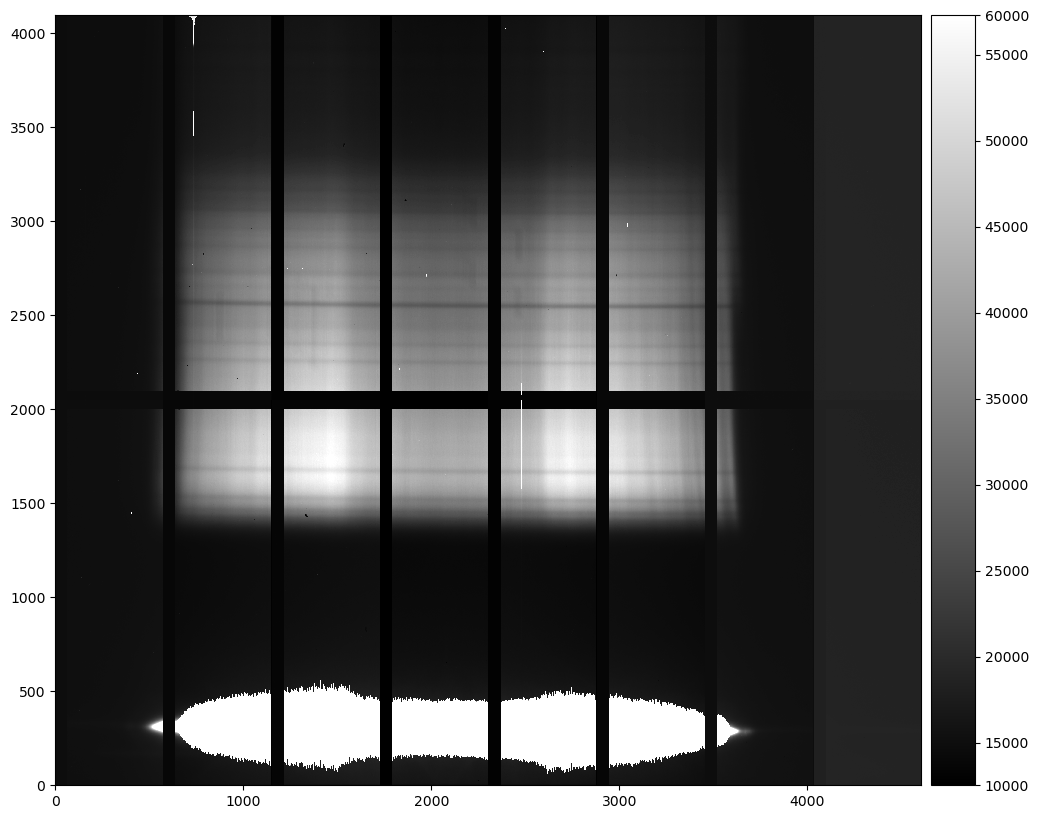

In [22]:
fig = plt.figure(figsize=(12,10))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(test_img.image)

## Organize amplifiers 

In [23]:
ampli_boxes = {}
ampli_names = []
for ampIdx, amp in enumerate(test_img.getDetector()):
    ampli_name_ = amp.getName()
    ampli_names.append(ampli_name_)
    xbegin = amp.getBBox().x.begin
    xend = amp.getBBox().x.end
    ybegin = amp.getBBox().y.begin
    yend = amp.getBBox().y.end
    ampli_boxes[ampli_name_] = (xbegin,xend,ybegin,yend)

In [24]:
ampli_boxes

{'C10': (0, 509, 2000, 4000),
 'C11': (509, 1018, 2000, 4000),
 'C12': (1018, 1527, 2000, 4000),
 'C13': (1527, 2036, 2000, 4000),
 'C14': (2036, 2545, 2000, 4000),
 'C15': (2545, 3054, 2000, 4000),
 'C16': (3054, 3563, 2000, 4000),
 'C17': (3563, 4072, 2000, 4000),
 'C07': (3563, 4072, 0, 2000),
 'C06': (3054, 3563, 0, 2000),
 'C05': (2545, 3054, 0, 2000),
 'C04': (2036, 2545, 0, 2000),
 'C03': (1527, 2036, 0, 2000),
 'C02': (1018, 1527, 0, 2000),
 'C01': (509, 1018, 0, 2000),
 'C00': (0, 509, 0, 2000)}

We do the ISR on this image the same way we do it with the spectra images (i.e., we do our pseudo-postISRCCD): 

In [25]:
# configuration
isr_config =  IsrTaskConfig()

In [26]:
isr_config.doDark = False
isr_config.doFlat =  False
isr_config.doFringe = False
isr_config.doDefect = True
isr_config.doLinearize = False
isr_config.doCrosstalk =  False
isr_config.doSaturationInterpolation = False
isr_config.overscan.fitType: 'MEDIAN_PER_ROW'
isr_config.doBias: True


In [27]:
isr_task = IsrTask(config=isr_config)

In [28]:
butler = dafButler.Butler(repo, collections=calibCollections)
camera = butler.get('camera', instrument=cameraName)
#bias = butler.get('bias',instrument=cameraName,detector=0)
#defects = butler.get('defects',instrument=cameraName,detector=0)

In [29]:

bias = butler.get("bias",instrument=cameraName, exposure= exp_id0, detector=0, collections=calibCollections)
defects = butler.get('defects',instrument=cameraName, exposure= exp_id0,detector=0,collections=calibCollections)

#fast ISR 
isr_test = isr_task.run(test_img,bias=bias,defects=defects)


In [30]:
test_ = isr_test.exposure.image.array

Value range 

In [31]:
np.min(test_.flatten())

-60302.95

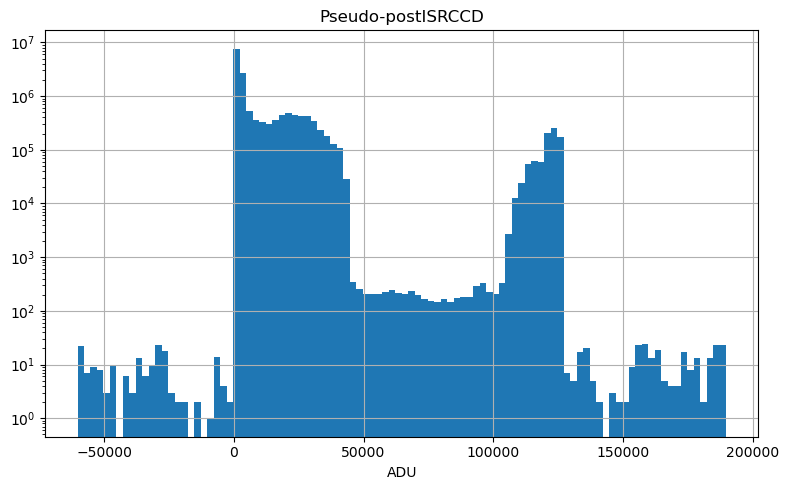

In [32]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
_ = ax.hist(test_.flatten(),bins=100)
ax.set_yscale("log")
ax.grid()
ax.set_xlabel('ADU')
ax.set_title('Pseudo-postISRCCD')
plt.tight_layout()

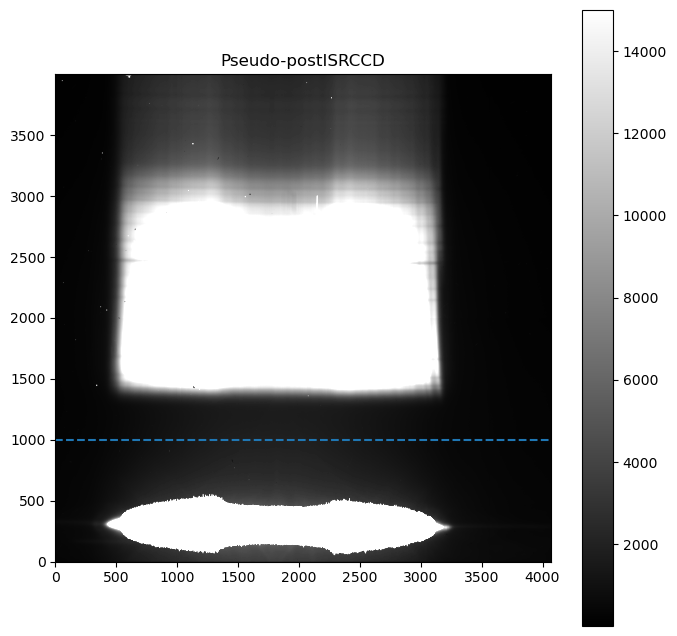

In [33]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(test_,cmap="gray",origin='lower',vmin=10,vmax=15000)
ax.axhline(y=1000,ls='--')
ax.set_title('Pseudo-postISRCCD')
fig.colorbar(im,ax=ax)

In [34]:
#proj = np.sum(test_[1200:,:],axis=0)
proj_up = np.median(test_[2000:,:],axis=0)
proj_down = np.median(test_[1000:2000,:],axis=0)
proj = np.mean([proj_up,proj_down],axis=0)
print(test_.shape,proj_up.shape,proj_down.shape,proj.shape)
x_ = np.arange(proj.shape[0])

(4000, 4072) (4072,) (4072,) (4072,)


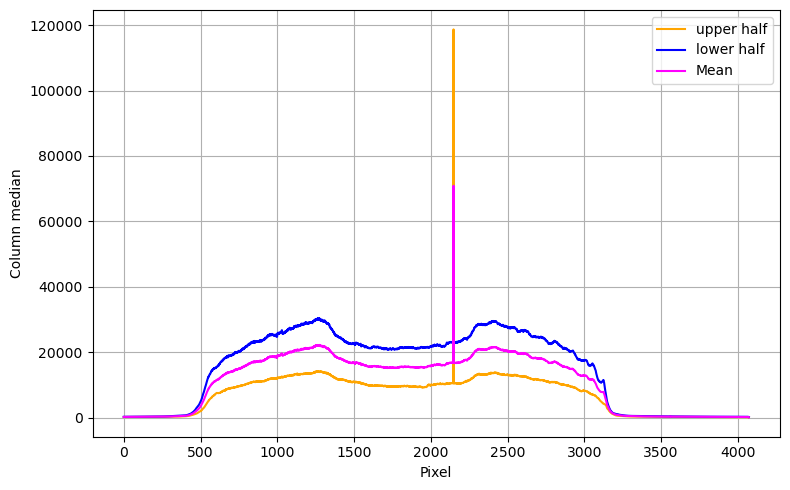

In [35]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(x_,proj_up,color='orange',label='upper half')
ax.plot(x_,proj_down,color='b',label='lower half')
ax.plot(x_,proj,color='magenta',label='Mean')
ax.grid()
ax.set_xlabel('Pixel')
ax.set_ylabel('Column median')
ax.legend(loc="best")
plt.tight_layout()

In [36]:
#test_deproj = np.zeros(test_.shape)
#test_deproj[2000:,:] = test_[2000:,:]/proj_up[None,:]
#test_deproj[:2000,:] = test_[:2000,:]/proj_down[None,:]
test_deproj = test_/proj[None,:]
print(test_deproj.shape)

(4000, 4072)


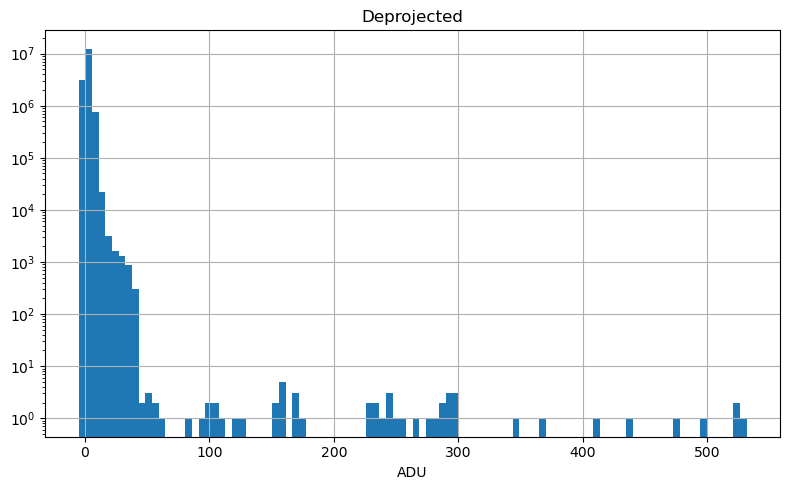

In [37]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
_ = ax.hist(test_deproj.flatten(),bins=100)
ax.set_yscale("log")
ax.grid()
ax.set_xlabel('ADU')
ax.set_title('Deprojected')
plt.tight_layout()

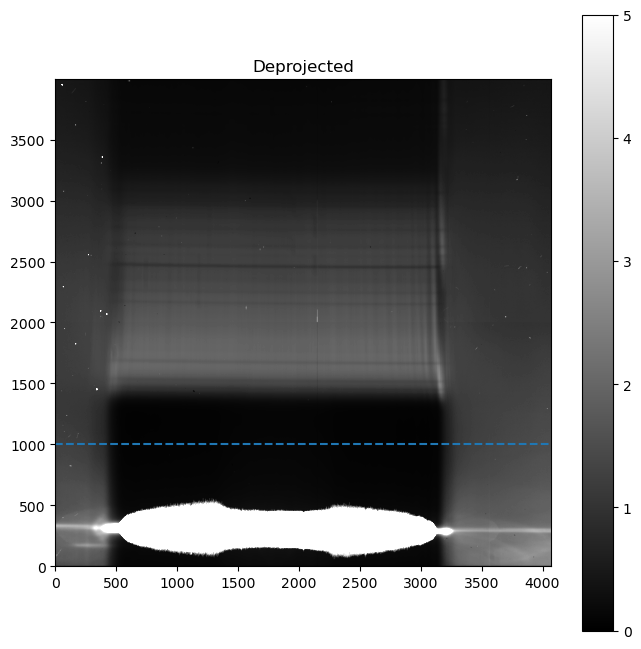

In [38]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#im = ax.imshow(test_norm1,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(test_deproj,cmap="gray",origin='lower',vmin=0,vmax=5)
ax.axhline(y=1000,ls='--')
ax.set_title('Deprojected')
fig.colorbar(im,ax=ax)

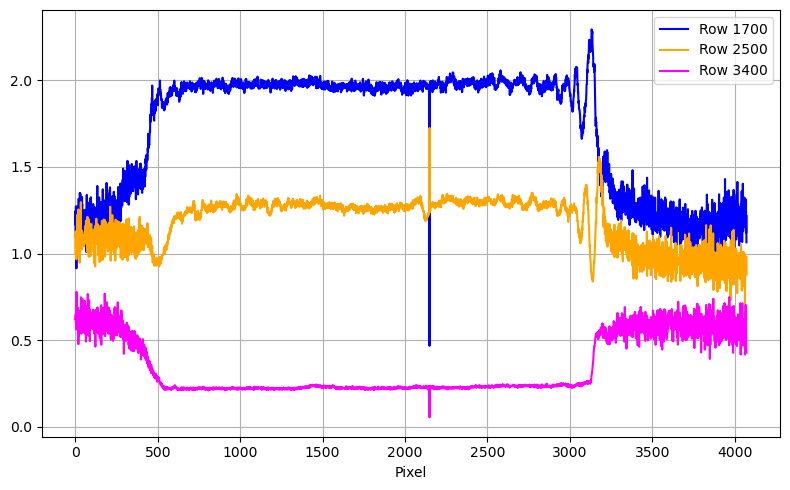

In [39]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(x_,test_deproj[1700,:],color='b',label='Row 1700')
ax.plot(x_,test_deproj[2500,:],color='orange',label='Row 2500')
ax.plot(x_,test_deproj[3400,:],color='magenta',label='Row 3400')
ax.grid()
ax.set_xlabel('Pixel')
ax.legend(loc="best")
plt.tight_layout()

## Wavelength (row) normalization per amplifier 

In [40]:

print(test_deproj.shape)

test_lnorm = np.zeros(test_deproj.shape)
for key in ampli_boxes.keys():
    x0 = ampli_boxes[key][0]
    x1 = ampli_boxes[key][1]
    y0 = ampli_boxes[key][2]
    y1 = ampli_boxes[key][3]
    ampli_ = test_deproj[y0:y1,x0:x1]
    median_ = np.median(ampli_,axis=1)

    norm_ampli_ = ampli_/median_[:,None]
    print(norm_ampli_.shape)

    test_lnorm[y0:y1,x0:x1] = norm_ampli_
print(test_lnorm.shape)
print('-------------')


(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------


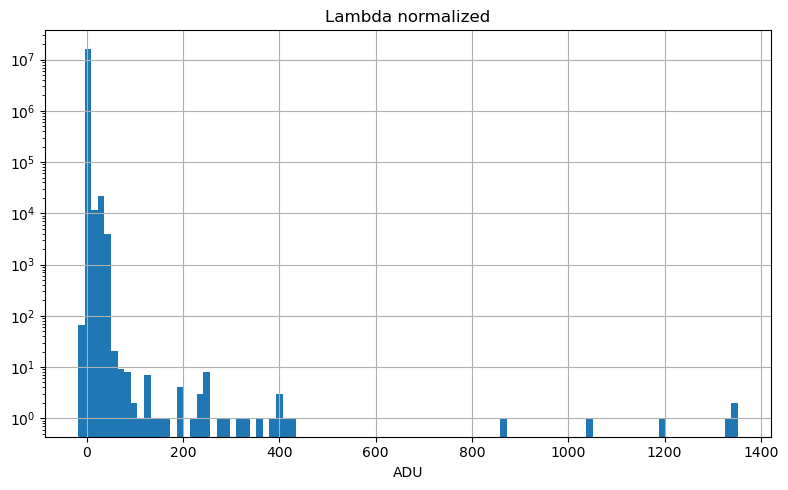

In [41]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
_ = ax.hist(test_lnorm.flatten(),bins=100)
ax.set_yscale("log")
ax.grid()
ax.set_xlabel('ADU')
ax.set_title('Lambda normalized')
plt.tight_layout()

In [42]:
# allow interactive plots
#%matplotlib widget
%matplotlib inline

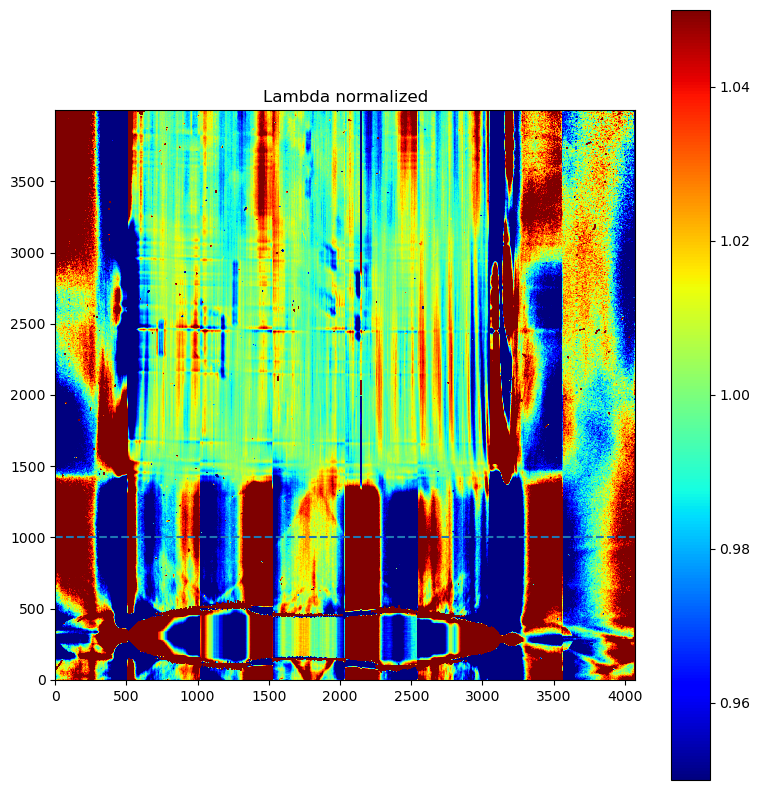

In [43]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#im = ax.imshow(test_norm1,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(test_lnorm,cmap="jet",origin='lower',vmin=0.95,vmax=1.05)
ax.axhline(y=1000,ls='--')
ax.set_title('Lambda normalized')
fig.colorbar(im,ax=ax)
plt.tight_layout()

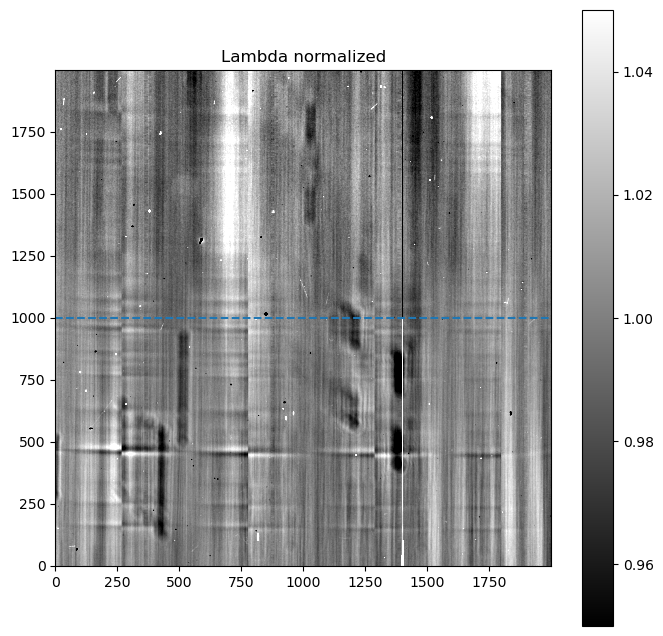

In [44]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#im = ax.imshow(test_norm1,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(test_lnorm[2000:4000,750:2750],cmap="gray",origin='lower',vmin=0.95,vmax=1.05)
ax.axhline(y=1000,ls='--')
ax.set_title('Lambda normalized')
fig.colorbar(im,ax=ax)

# Compare moving exposures 

## 1. Do pseudo-postISRCCD 

In [45]:
print(seq_nums)

[207 208 209 210 211 212]


In [46]:
exp_list = []
ampli_boxes = {}
ampli_names = []
for i,exp_id_ in enumerate(ids):
    print(exp_id_)
    raw_img_ = butler.get('raw', dataId={'exposure': exp_id_, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)
    print('Raw image retrieved')
    
    bias_ = butler.get("bias",instrument=cameraName, exposure= exp_id_, detector=0, collections=calibCollections)
    defects_ = butler.get('defects',instrument=cameraName, exposure= exp_id_,detector=0,collections=calibCollections)
    
    #fast ISR 
    print('Running pseudo-ISR')
    isr_img_ = isr_task.run(raw_img_,bias=bias_,defects=defects_)
    
    exp_list.append(isr_img_)
    print('-----------------')
    
    if i==0:
        for ampIdx, amp in enumerate(raw_img_.getDetector()):
            ampli_name_ = amp.getName()
            ampli_names.append(ampli_name_)
            xbegin = amp.getBBox().x.begin
            xend = amp.getBBox().x.end
            ybegin = amp.getBBox().y.begin
            yend = amp.getBBox().y.end
            ampli_boxes[ampli_name_] = (xbegin,xend,ybegin,yend)
            
            md = raw_img_.getMetadata().toDict()
    

2023092700207
Raw image retrieved
Running pseudo-ISR


-----------------
2023092700208
Raw image retrieved
Running pseudo-ISR


-----------------
2023092700209
Raw image retrieved
Running pseudo-ISR


-----------------
2023092700210
Raw image retrieved
Running pseudo-ISR


-----------------
2023092700211
Raw image retrieved
Running pseudo-ISR


-----------------
2023092700212
Raw image retrieved
Running pseudo-ISR


-----------------


In [47]:
ampli_boxes

{'C10': (0, 509, 2000, 4000),
 'C11': (509, 1018, 2000, 4000),
 'C12': (1018, 1527, 2000, 4000),
 'C13': (1527, 2036, 2000, 4000),
 'C14': (2036, 2545, 2000, 4000),
 'C15': (2545, 3054, 2000, 4000),
 'C16': (3054, 3563, 2000, 4000),
 'C17': (3563, 4072, 2000, 4000),
 'C07': (3563, 4072, 0, 2000),
 'C06': (3054, 3563, 0, 2000),
 'C05': (2545, 3054, 0, 2000),
 'C04': (2036, 2545, 0, 2000),
 'C03': (1527, 2036, 0, 2000),
 'C02': (1018, 1527, 0, 2000),
 'C01': (509, 1018, 0, 2000),
 'C00': (0, 509, 0, 2000)}

In [48]:
mapampid = [0,1,2,3,4,5,6,7,15,14,13,12,11,10,9,8]

In [49]:
num_amplis = len(mapampid)

## 2. Wavelength (row) normalization 

We test the normalization with one exposure 

In [50]:
exp0 = exp_list[0].exposure.image.array

In [51]:
print(exp0.shape)

(4000, 4072)


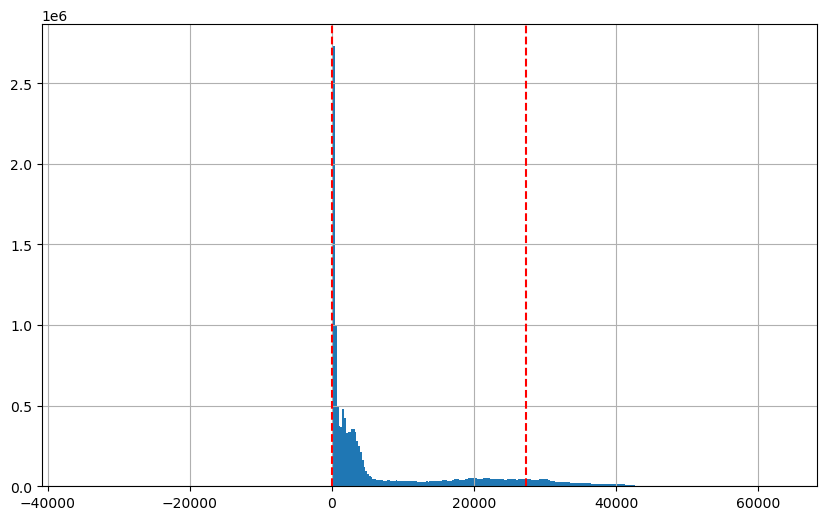

In [53]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
_ = ax.hist(exp0.flatten(),bins=1000)
mu = np.mean(exp0.flatten())
sigma = np.std(exp0.flatten())
nsigma = 0.5
ax.axvline(x=mu-nsigma*sigma,ls='--',color='r')
ax.axvline(x=mu+nsigma*sigma,ls='--',color='r')
ax.set_xlim(mu-2.*sigma,mu+2.*sigma)
ax.grid()

In [54]:
vmin = 1
vmax = 6000

(0.0, 4000.0)

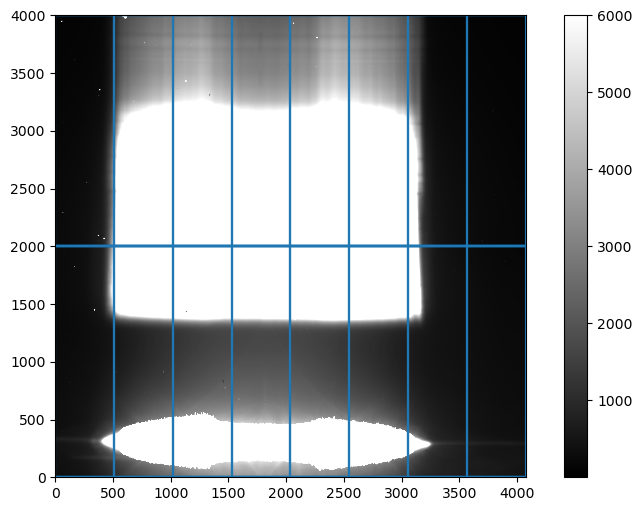

In [55]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
im = ax.imshow(exp0,cmap="gray",origin='lower',vmin=vmin,vmax=vmax)#,norm=LogNorm())
fig.colorbar(im,ax=ax)
for key in ampli_boxes.keys():
    ax.axvline(x=ampli_boxes[key][0])
    ax.axvline(x=ampli_boxes[key][1])
    ax.axhline(y=ampli_boxes[key][2])
    ax.axhline(y=ampli_boxes[key][3])
ax.set_xlim(0,4072)
ax.set_ylim(0,4000)

Visualize data per amplifier separately 

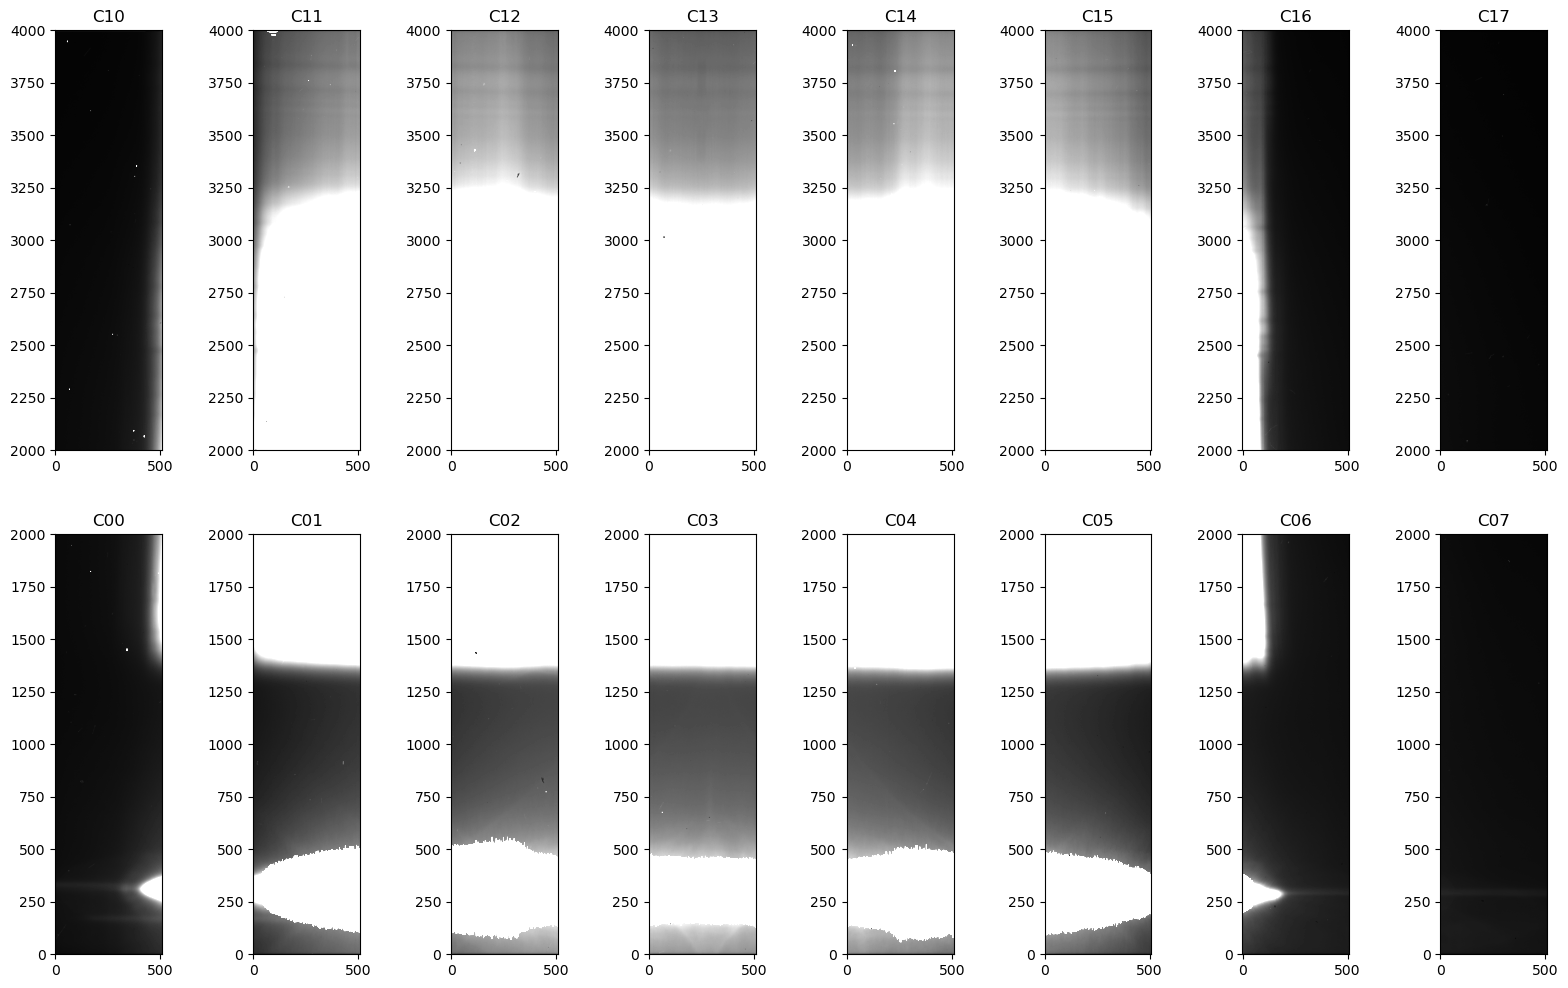

In [56]:
fig = plt.figure(figsize=(20,12))

for i,key in enumerate(ampli_boxes.keys()):
    x0 = ampli_boxes[key][0]
    x1 = ampli_boxes[key][1]
    y0 = ampli_boxes[key][2]
    y1 = ampli_boxes[key][3]
    ampli_ = exp0[y0:y1,x0:x1]
    
    ax = fig.add_subplot(2,8,mapampid[i]+1)
    im = ax.imshow(ampli_,cmap="gray",origin='lower',vmin=vmin,vmax=vmax)#,norm=LogNorm())
    yticks = ax.get_yticks()
    #print(yticks)
    ax.set_yticks(ticks=yticks[1:],labels=yticks[1:].astype('int')+y0)
    ax.set_title(key)

We normalize each row (per amplifier) to their median value. This way, we can compare exposure with different number counts (due to different effective exposure times) 

(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)


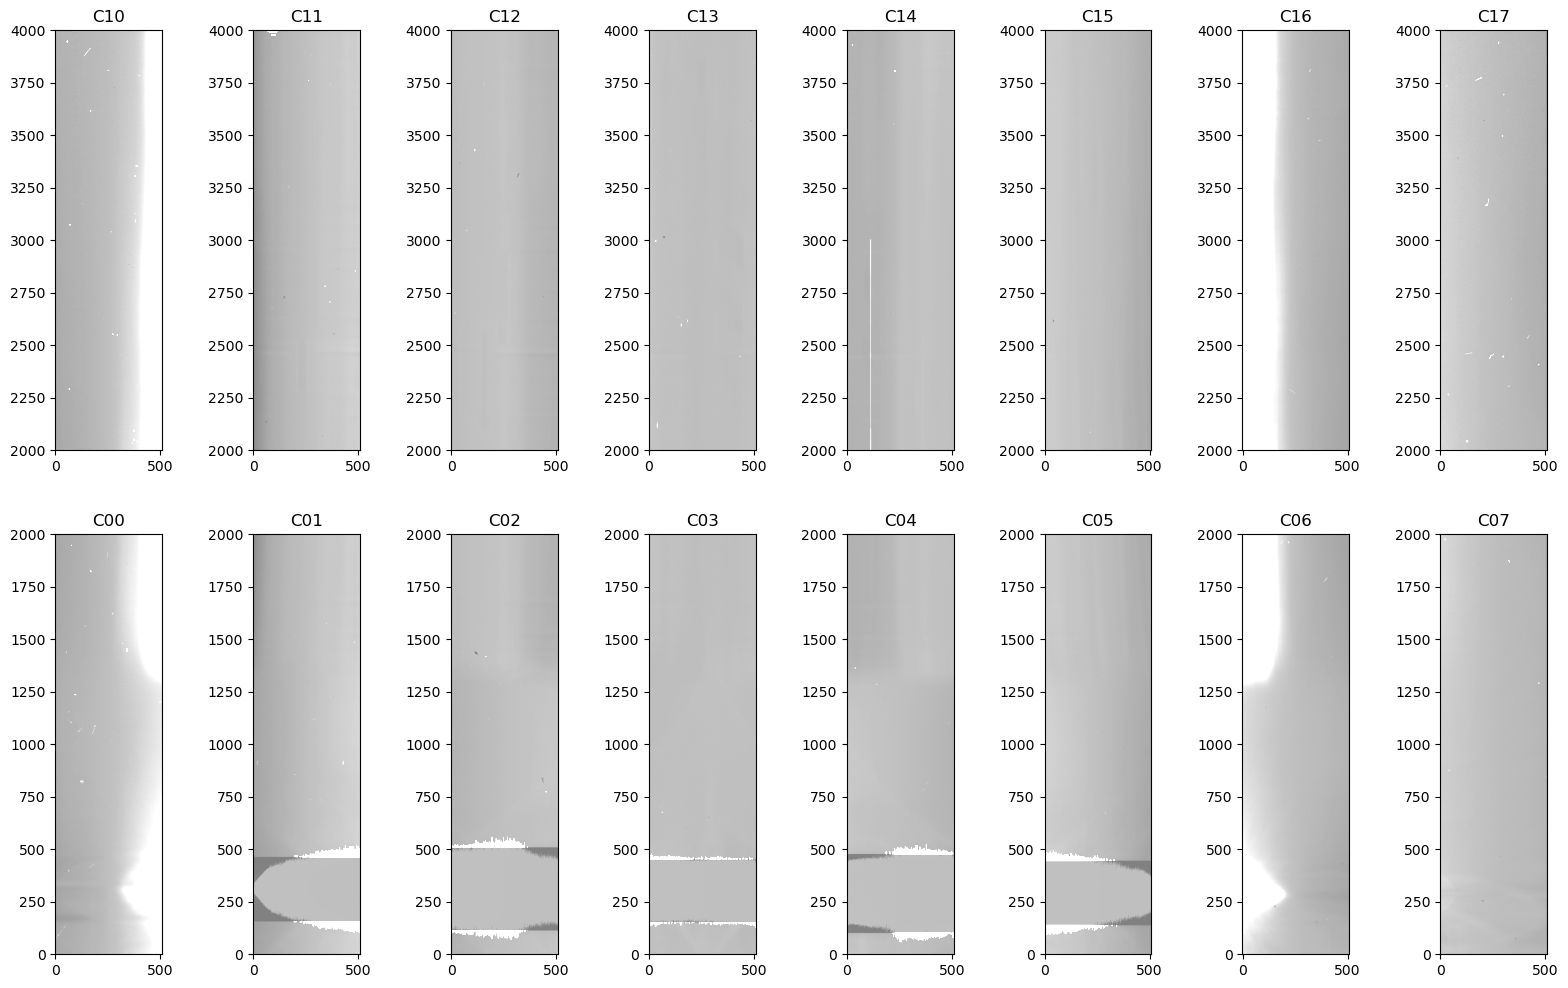

In [57]:
fig = plt.figure(figsize=(20,12))

for i,key in enumerate(ampli_boxes.keys()):
    x0 = ampli_boxes[key][0]
    x1 = ampli_boxes[key][1]
    y0 = ampli_boxes[key][2]
    y1 = ampli_boxes[key][3]
    ampli_ = exp0[y0:y1,x0:x1]
    median_ = np.median(ampli_,axis=1)
    
    norm_ampli_ = ampli_/median_[:,None]
    print(norm_ampli_.shape)
    
    ax = fig.add_subplot(2,8,mapampid[i]+1)
    im = ax.imshow(norm_ampli_,cmap="gray",origin='lower',vmin=-2,vmax=2)#,norm=LogNorm())
    yticks = ax.get_yticks()
    #print(yticks)
    ax.set_yticks(ticks=yticks[1:],labels=yticks[1:].astype('int')+y0)
    ax.set_title(key)


Now we do this systematically for all exposures and we combine taking their median pixel by pixel 

In [58]:
print(len(exp_list))

6


In [59]:
special_flat_ = []
for i,exp_ in enumerate(exp_list):
    print(i)
    data_ = exp_.exposure.image.array
    print(data_.shape)
    
    out_ = np.zeros(data_.shape)
    for key in ampli_boxes.keys():
        x0 = ampli_boxes[key][0]
        x1 = ampli_boxes[key][1]
        y0 = ampli_boxes[key][2]
        y1 = ampli_boxes[key][3]
        ampli_ = data_[y0:y1,x0:x1]
        median_ = np.median(ampli_,axis=1)

        norm_ampli_ = ampli_/median_[:,None]
        print(norm_ampli_.shape)
        
        out_[y0:y1,x0:x1] = norm_ampli_
    print(out_.shape)
    special_flat_.append(out_)
    print('-------------')
special_flat_ = np.array(special_flat_)
print(special_flat_.shape)

0
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
1
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
2
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
3
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(4000, 4072)
-------------
4
(4000, 4072)
(2000, 509)
(2000, 509)
(2000, 509)
(2000, 509)
(

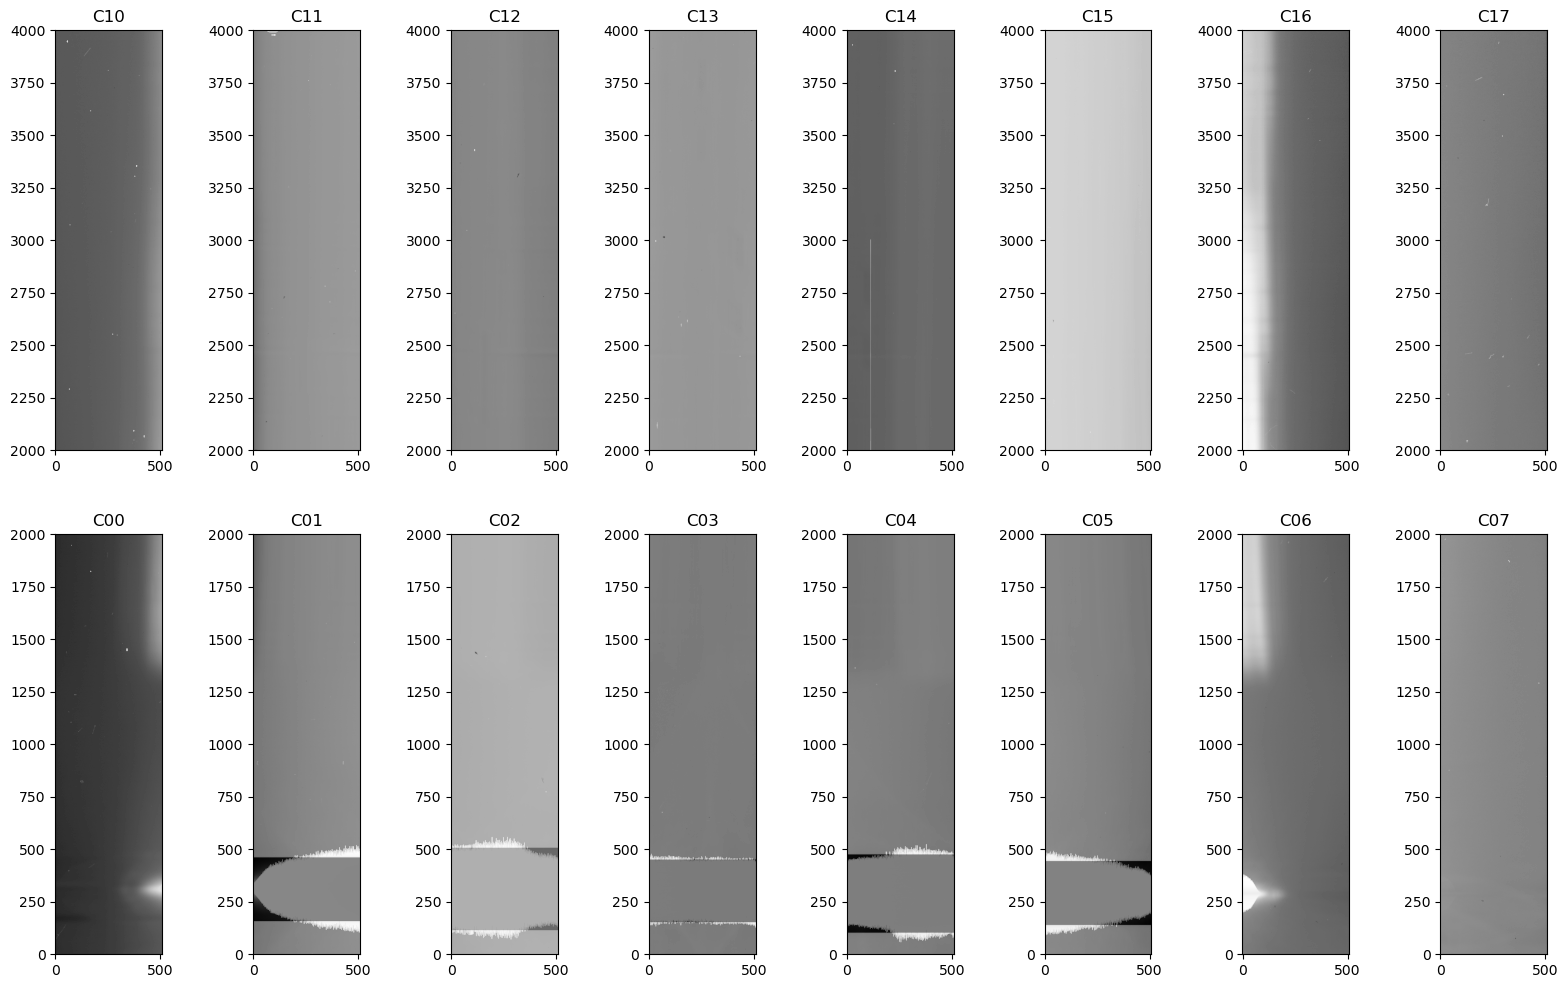

In [60]:
fig = plt.figure(figsize=(20,12))

for i,key in enumerate(ampli_boxes.keys()):
    x0 = ampli_boxes[key][0]
    x1 = ampli_boxes[key][1]
    y0 = ampli_boxes[key][2]
    y1 = ampli_boxes[key][3]
    ampli_ = special_flat_[0][y0:y1,x0:x1]
    
    ax = fig.add_subplot(2,8,mapampid[i]+1)
    im = ax.imshow(ampli_,cmap="gray",origin='lower',norm=LogNorm())
    yticks = ax.get_yticks()
    #print(yticks)
    ax.set_yticks(ticks=yticks[1:],labels=yticks[1:].astype('int')+y0)
    ax.set_title(key)

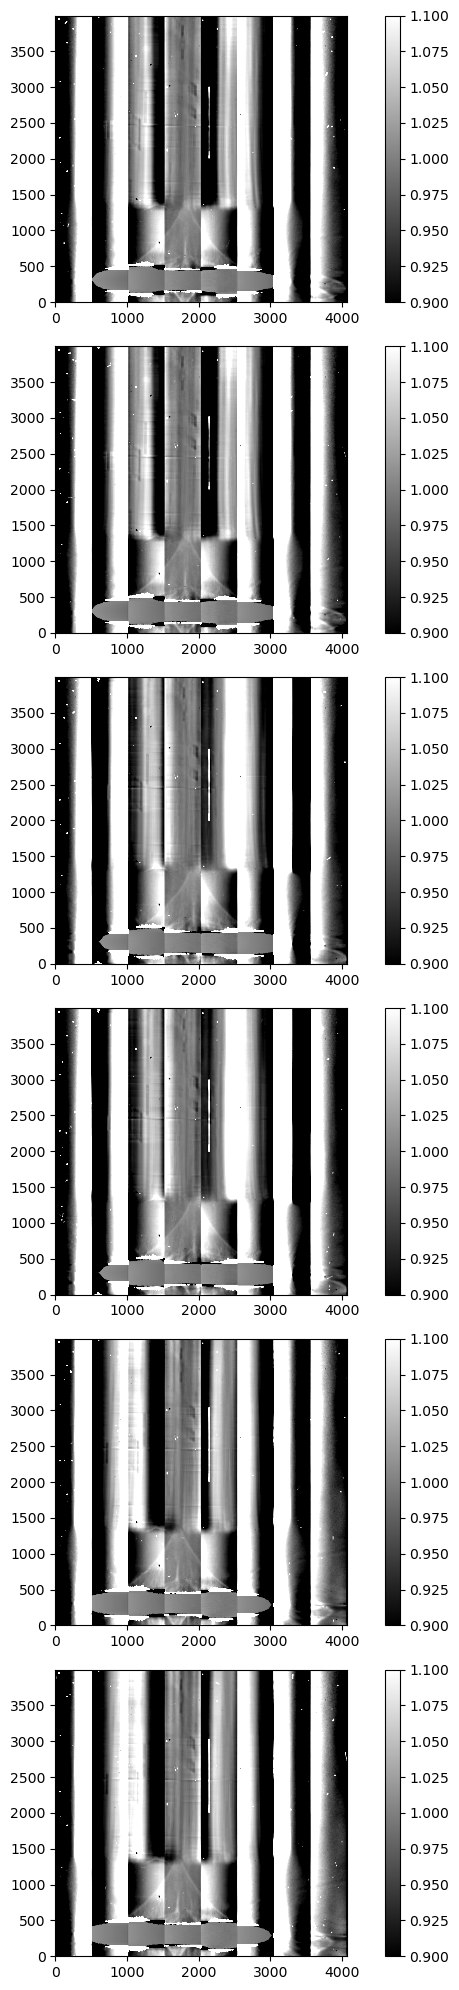

In [67]:
fig = plt.figure(figsize=(8,20))

for i,sf_ in enumerate(special_flat_):
    ax = fig.add_subplot(len(special_flat_),1,i+1)
    
    im = ax.imshow(sf_,cmap="gray",origin='lower',vmin=0.9,vmax=1.1)#,norm=LogNorm())
    fig.colorbar(im,ax=ax)
    
plt.tight_layout()